<a href="https://colab.research.google.com/github/parikh-dharit/super_resolution/blob/master/sup_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Pytorch and other libraries/packages

In [2]:
!pip3 install torch torchvision torchsummary numpy matplotlib Pillow

In [0]:
from __future__ import print_function
import argparse
from math import log10

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
#from model import Net
#from data import get_training_set, get_test_set
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ToTensor, Compose, CenterCrop, Resize

import matplotlib.pyplot as plt
import numpy as np
import PIL


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Initialize the settings/variables

In [69]:
'''
# Training settings
parser = argparse.ArgumentParser(description='PyTorch Super Res Example')
parser.add_argument('--upscale_factor', type=int, required=True, help="super resolution upscale factor")
parser.add_argument('--batchSize', type=int, default=64, help='training batch size')
parser.add_argument('--testBatchSize', type=int, default=10, help='testing batch size')
parser.add_argument('--nEpochs', type=int, default=2, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.01, help='Learning Rate. Default=0.01')
parser.add_argument('--model', type=str, default='model', help='model/network file to use')
parser.add_argument('--init_model', type=str, help='model to initialize with?')
parser.add_argument('--cuda', action='store_true', help='use cuda?')
parser.add_argument('--threads', type=int, default=4, help='number of threads for data loader to use')
parser.add_argument('--seed', type=int, default=123, help='random seed to use. Default=123')
opt = parser.parse_args()

print(opt)

if opt.cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

torch.manual_seed(opt.seed)

device = torch.device("cuda" if opt.cuda else "cpu")

def show_dataset(dataset, train=True,n=5):

'''
upscale_factor = 3
batchSize = 32
testBatchSize = 4
nEpochs = 20
lr = 0.01
threads = 4
seed = 321

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

torch.manual_seed(seed)

Stacks the first n=6 transformed elements

In [0]:
def tensorTo_unnorm(norm_img):
  un_img = norm_img.detach().numpy()
  un_img *= 255.0
  un_img = un_img.clip(0, 255)
  un_img = un_img.reshape(un_img.shape[-2],un_img.shape[-1])
  return un_img
def show_dataset1(dataset, n=6):
  for o in range(2):
    img = np.vstack((np.hstack((np.asarray(tensorTo_unnorm(dataset[i][o]), dtype=int) for _ in range(n)))
                     for i in range(len(dataset))))
    imgs_comb = PIL.Image.fromarray(img)
    plt.imshow(imgs_comb)
    plt.axis('off')
def show_dataset2(dataset, n=5):
  for o in range(2):
    img = np.vstack((np.hstack((np.asarray(dataset[i+3][o]) for _ in range(n)))
                     for i in range(6)))
    if o==0:
      imgs_comb_inp = PIL.Image.fromarray(img)
    elif o==1:
      imgs_comb_tar = PIL.Image.fromarray(img)
  
  return imgs_comb_inp, imgs_comb_tar
def show_dataset(dataset, n=5):
  '''
  inp = np.vstack(
                    ( np.hstack(
                         ( np.asarray(dataset[i+3][o]) for _ in range(n))  
                      ) 
                      for i in range(6)
                    )
                 )
  '''
  #print(dataset[3][0].size)
  ls = ( np.asarray(dataset[3][0]) for _ in range(n))
  #print("length of ls: ",len(ls))
  #print("shape of ls[0]: ",next(ls).shape)
  hs = np.hstack(ls)
  #print("shape of hs[0]: ",hs.shape)
  inp_list = []
  tar_list = []
  for i in range(6):
    inp = []
    tar = []
    for _ in range(n):
      inp_m, tar_m = dataset[i+7]
      inp.append(inp_m)
      tar.append(tar_m)
      #inp.append(dataset[i+7][0])
      #tar.append(dataset[i+7][1])
      #inp = np.append(inp, np.asarray(dataset[i+3][0]))
      #tar = np.append(tar, np.asarray(dataset[i+3][1]))
    inp_list.append(np.hstack(inp))
    tar_list.append(np.hstack(tar))
    #if i==0:
    #  print("shape of hs(inp_list): ", inp_list[0].shape)
  img0 = np.vstack(inp_list)
  img1 = np.vstack(tar_list)
  #print(inp.shape)
  imgs_comb_inp = PIL.Image.fromarray(img0)
  imgs_comb_tar = PIL.Image.fromarray(img1)
  
  return imgs_comb_inp, imgs_comb_tar
  #img = np.vstack((np.hstack((np.asarray(dataset[i+3][o]) for _ in range(n)))
  #                 for i in range(7)))
  #imgs_comb = PIL.Image.fromarray(img)  
  #return imgs_comb

In [7]:
!ls

dataset  sample_data


In [0]:
from os.path import exists, join, basename
from os import makedirs, remove, listdir, walk
from six.moves import urllib
import tarfile
import zipfile
import torch.utils.data as data
import shutil
import os
import time

Dataset file structure:

/dataset

    /dataset-name
    
        /images
        
            /train
            
                /image01.png
                ...
                
            /test
            
                /image01.png
                ...
                
images location: /dataset/dataset-name/train/image05.png  

In [0]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


In [0]:
def download_bsd300(dest="dataset"):
    output_image_dir = join(dest, "BSDS300/images")

    if not exists(output_image_dir):
        makedirs(dest)
        url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        print("downloading url ", url)

        data = urllib.request.urlopen(url)

        file_path = join(dest, basename(url))
        with open(file_path, 'wb') as f:
            f.write(data.read())

        print("Extracting data")
        with tarfile.open(file_path) as tar:
            for item in tar:
                tar.extract(item, dest)

        remove(file_path)
    return output_image_dir

In [0]:
def download_div2k(dest="dataset"):
    output_image_dir = join(dest, "DIV2K/images")
    train_dest = join(output_image_dir, "train")
    test_dest = join(output_image_dir, "test")
    if not (exists(output_image_dir) and exists(train_dest) and exists(test_dest)):
        if not exists(output_image_dir):
          makedirs(dest)
        
        if not exists(train_dest):
          makedirs(train_dest)
          url = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
          print("train: downloading url ", url)
          
          file_path = join(dest, basename(url))
          if not exists(file_path):
            data_train = urllib.request.urlopen(url)
            
            #file_path = join(dest, basename(url))
            with open(file_path, 'wb') as f:
              f.write(data_train.read())
            
          print("Extracting data")
          zip_ref = zipfile.ZipFile(file_path, 'r')
          zip_ref.extractall(train_dest)
          zip_ref.close()
          remove(file_path)
          source_files = 'dataset/DIV2K/images/train/DIV2K_train_HR'
          dest1_files = 'dataset/DIV2K/images/train'
          files_to_move = os.listdir(source_files)
          for f in files_to_move:
            if is_image_file(join(source_files, f)):
              shutil.move(join(source_files, f), dest1_files)
          os.rmdir(source_files)
        
        if not exists(test_dest):
          makedirs(test_dest)
          url = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip"
          print("test: downloading url ", url)
          
          file_path = join(dest, basename(url))
          if not exists(file_path):
            data_test = urllib.request.urlopen(url)

            #file_path = join(dest, basename(url))
            with open(file_path, 'wb') as f:
              f.write(data_test.read())

          print("Extracting data")
          zip_ref = zipfile.ZipFile(file_path, 'r')
          zip_ref.extractall(test_dest)
          zip_ref.close()
          remove(file_path)
          source_files = 'dataset/DIV2K/images/test/DIV2K_valid_HR'
          dest1_files = 'dataset/DIV2K/images/test'
          files_to_move = os.listdir(source_files)
          for f in files_to_move:
            if is_image_file(join(source_files, f)):
              shutil.move(join(source_files, f), dest1_files)
          os.rmdir(source_files)
    
    return output_image_dir

In [0]:
def load_img(filepath):
    img = PIL.Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y


In [0]:
def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

In [0]:
def original_transform(crop_size):
    return Compose([
        CenterCrop(crop_size),
        RandomHorizontalFlip(),
        #RandomRotation(20, resample=PIL.Image.BILINEAR),
        #ToTensor(),
    ])


In [0]:
def input_transform(crop_size, upscale_factor):
    return Compose([
        #CenterCrop(crop_size),
        Resize(crop_size // upscale_factor),
        ToTensor(), #comment so that we can show images
    ])


In [0]:
def target_transform():
    return Compose([
        #CenterCrop(crop_size),
        #Resize(crop_size // upscale_factor),
        ToTensor(), #comment so that we can show images, show_dataset()
    ])


In [0]:
#custom image resize function, where image size doesn't exceed a certain threshold
def image_size_changes(img, up_factor):
    he, wi = img.size
    d_sample = 1
    while (he//d_sample)*(wi//d_sample) > (100000):
        d_sample += 1
    img = img.resize((he//d_sample, wi//d_sample), Image.ANTIALIAS)
    he, wi = img.size
    new_he = (he//up_factor) *up_factor
    new_wi = (wi//up_factor) *up_factor
    img = img.crop((0, 0, new_he, new_wi))
    tr_img = img.copy()
    img = img.resize((new_he//up_factor, new_wi//up_factor), Image.ANTIALIAS)
    return img, tr_img


In [0]:
def image_filenames(image_dir):
  file_list = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]
  return file_list

In [0]:
def video_filenames(image_dir):
  #video_filenames (folders)
  file_list = []
  #print(len(files)-2)
  for root, dirs, files in os.walk(image_dir):
    files.sort()
    for i in range(len(files)-2):#for x in files:
      temp_lst = []
      for j in range(3):
          if is_image_file(files[i+j]):
              temp_lst.append(join(root,files[i+j]))
          else:
              print("Not image")
              print(files[i+j])
      self.file_list.append(temp_lst) 

  #vid_filelist


  #current_file - no, create a mapping between index and file,frame
  return file_list

To do:

Figure out how to apply same transformation to multiple frames for video sup_res

In [0]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, input_transform=None, original_transform=None, target_transform=None, image_video = "image", upscale_factor=3):
        super(DatasetFromFolder, self).__init__()
        #self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]
        self.image_video = image_video
        if(self.image_video == "image"):
          self.filenames = image_filenames(image_dir)
        else:
          self.filenames = video_filenames(image_dir)
        self.upscale_factor = upscale_factor
        self.input_transform = input_transform
        self.original_transform = original_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        if(self.image_video == "image"):
          input = load_img(self.filenames[index])        
          input = self.original_transform(input)
          target = input.copy()
          if self.input_transform:
              input = self.input_transform(input)
          if self.target_transform:
              target = self.target_transform(target)
          return input, target
        
        else:
          input = []
          #print(self.vid_filelist[index][1])
          for j in range(3):
            try:
                input.append(load_img(self.filenames[index][j]))
                input[j] = self.original_transform(input[j])#remove random horizontal flips
            except:
                print(index)
                print(j)
                print(self.filenames[index])
                print(self.filenames[index][j])
          target = input[1]
          
          if self.input_transform:
            for j in range(3):
                input[j] = self.input_transform(input[j])
            #input = torch.cat(input)#[3,85,85]
            #when multiple frames are fed as multiple channels uncomment the line above
            #and comment line below
            input = torch.stack(input)##[3,1,85,85]
            #input = input.reshape(1, 3, 85, 85) #[3,1,85,85] -> [1, 3, 85, 85]
            #print(input.shape)
            input = input.reshape(input.shape[1],input.shape[0],input.shape[2],input.shape[3])
            
          if self.target_transform:
            target = self.target_transform(target)
            
          '''
          self.filenames = video_filenames(image_dir)
          input = load_img(self.image_filenames[index])

          #input = RandomHorizontalFlip(input),
          #input = RandomRotation(input, 20, resample=Image.BILINEAR)
          input = self.original_transform(input)
          #he, wi = input.size
          #new_he = (he//self.upscale_factor) * self.upscale_factor
          #new_wi = (wi//self.upscale_factor) * self.upscale_factor
          #input = input.crop((0, 0, new_he, new_wi))
          #target = input.copy()          
          
          if self.input_transform:
              #desired_size = (he//self.upscale_factor, wi//self.upscale_factor)
              #print(desired_size)
              #input = F.resize(input, desired_size, 'PIL.Image.BILINEAR')
              #input = Resize(input, desired_size)
              #input = input.resize(desired_size, Image.ANTIALIAS)
              #input = self.input_transform(input)
          if self.target_transform:
              #target = self.target_transform(target)
          #print(("index:{}, or_size:{}-{}, in_size:{}-{}, tar_size:{}-{}").format(index,he,wi,desired_size[0],desired_size[1],new_he,new_wi))
          #print(target.shape)
          #print(("index:{}, in_size:{}-{}, tar_size:{}-{}").format(index,input.size[0],input.size[1],target.size[0],target.size[1]))
          '''
          return input, target

    def __len__(self):
        return len(self.filenames)
        


In [0]:
def get_training_set(upscale_factor):
    root_dir = download_div2k()
    #root_dir = video_dataset()
    train_dir = join(root_dir, "train")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(train_dir,
                             original_transform=original_transform(crop_size),
                             input_transform=input_transform(crop_size, upscale_factor),
                             target_transform=target_transform())


In [0]:
def get_test_set(upscale_factor):
    #root_dir = t91_dataset()
    root_dir = download_div2k()
    test_dir = join(root_dir, "test")
    crop_size = calculate_valid_crop_size(256, upscale_factor)

    return DatasetFromFolder(test_dir,
                             input_transform=input_transform(crop_size, upscale_factor),
                             original_transform=original_transform(crop_size),
                             target_transform=target_transform())

In [0]:
class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

In [57]:
print('===> Loading datasets')
train_set = get_training_set(upscale_factor)
test_set = get_test_set(upscale_factor)
print("Train set size: ", train_set.__len__())# -> 200
#print(train_set.__len__()) -> tuple of tensors
print(train_set.__getitem__(0)[0].size()) #-> tensor of [1, 85, 85]


===> Loading datasets
Train set size:  800
torch.Size([1, 85, 85])


In [58]:
!ls dataset/DIV2K/images/test

0801.png  0814.png  0827.png  0840.png	0853.png  0866.png  0879.png  0892.png
0802.png  0815.png  0828.png  0841.png	0854.png  0867.png  0880.png  0893.png
0803.png  0816.png  0829.png  0842.png	0855.png  0868.png  0881.png  0894.png
0804.png  0817.png  0830.png  0843.png	0856.png  0869.png  0882.png  0895.png
0805.png  0818.png  0831.png  0844.png	0857.png  0870.png  0883.png  0896.png
0806.png  0819.png  0832.png  0845.png	0858.png  0871.png  0884.png  0897.png
0807.png  0820.png  0833.png  0846.png	0859.png  0872.png  0885.png  0898.png
0808.png  0821.png  0834.png  0847.png	0860.png  0873.png  0886.png  0899.png
0809.png  0822.png  0835.png  0848.png	0861.png  0874.png  0887.png  0900.png
0810.png  0823.png  0836.png  0849.png	0862.png  0875.png  0888.png
0811.png  0824.png  0837.png  0850.png	0863.png  0876.png  0889.png
0812.png  0825.png  0838.png  0851.png	0864.png  0877.png  0890.png
0813.png  0826.png  0839.png  0852.png	0865.png  0878.png  0891.png


In [0]:
#commented ToTensor() in input and target transfrom function fpr show_dataset
imgs_comb_inp, imgs_comb_tar = show_dataset(train_set)

(-0.5, 424.5, 509.5, -0.5)

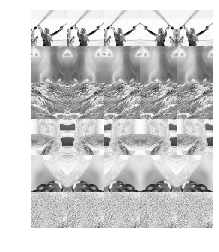

In [52]:
plt.imshow(imgs_comb_inp)
plt.axis('off')

(-0.5, 1274.5, 1529.5, -0.5)

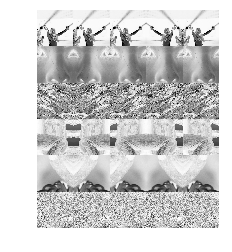

In [53]:
plt.imshow(imgs_comb_tar)
plt.axis('off')

In [0]:
training_data_loader = DataLoader(dataset=train_set, num_workers=threads, batch_size=batchSize, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=threads, batch_size=testBatchSize, shuffle=False)

In [60]:

print('===> Building model')
model = Net(upscale_factor=upscale_factor).to(device)
#model = torch.load(opt.model, map_location=device)

'''
#loading pre trained model
pre_trained2 = torch.load("model_epoch_93.pth", map_location='cpu')
dict2 = pre_trained2.state_dict()
print(dict2.keys())
#model = Net(upscale_factor=3).to('cpu')
#for name, param in model.named_parameters():
#    print("name: {}".format(name))
#    print("parameter shape: {}".format(param.shape))
dict3 = model.state_dict()
print(dict3.keys())

for name, param in model.named_parameters():
    if name == 'conv1.weight':
        for i in range(3):
            dict3[name][:,:,i,:,:] = dict1[name]
    else:
        dict3[name] = dict1[name]
        param.requires_grad = False
#end of pretrained model loading

'''

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=lr)


===> Building model


In [0]:
def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        start_time = time.time()
        input, target = batch[0].to(device), batch[1].to(device)
        '''
        if epoch==1:
            #print("training_data_loader size:")
            #print(training_data_loader.size())
            print("Input size:")
            print(input.size()) # [4,1,85,85], [batch_size, chnnels, dim1, dim2]
            print("Target size:")
            print(target.size()) # [4,1,255,255]
            #break#co
        '''
                    
        optimizer.zero_grad()
        loss = criterion(model(input), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        end_time = time.time()
        print("Time taken: ", end_time - start_time)

        print("===> Epoch[{}]({}/{}): Loss: {:.6f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))
    #f2.write("===> Avg. Loss: {:.4f}".format(epoch_loss / len(training_data_loader)))
    f2.write(" {:.6f}".format(epoch_loss / len(training_data_loader)))


In [0]:
def test():
    avg_psnr = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input, target = batch[0].to(device), batch[1].to(device)

            prediction = model(input)
            mse = criterion(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))
    #f1.write(" ===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))
    f1.write(" {:.6f}".format(avg_psnr / len(testing_data_loader)))
    return avg_psnr


In [0]:
def checkpoint(epoch, apsnr, last_ap):
    if epoch==1:
        last_ap = apsnr
    if apsnr >= last_ap :
        model_out_path = "model_epoch_{}.pth".format(epoch)
        torch.save(model, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))
        last_ap = apsnr
    return last_ap


In [68]:
print(model)
print("summary starts")        
summary(model, train_set.__getitem__(0)[0].size(), batch_size=batchSize)


Net(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)
summary starts
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 64, 85, 85]           1,664
              ReLU-2           [16, 64, 85, 85]               0
            Conv2d-3           [16, 64, 85, 85]          36,928
              ReLU-4           [16, 64, 85, 85]               0
            Conv2d-5           [16, 32, 85, 85]          18,464
              ReLU-6           [16, 32, 85, 85]               0
            Conv2d-7            [16, 9, 85, 85]           2,601
      PixelShuffle-8        

In [71]:
last_ap = 0
for epoch in range(1, nEpochs + 1):
    f2=open('train_loss.txt','a+')
    f2.write("\n" + str(epoch))
    train(epoch)
    f2.close()
    f1=open('test_psnr.txt','a+')
    f1.write("\n" + str(epoch))
    apsnr = test()
    f1.close()
    last_ap = checkpoint(epoch, apsnr, last_ap)


Input size:
torch.Size([16, 1, 85, 85])
Target size:
torch.Size([16, 1, 255, 255])
===> Epoch[1](1/50): Loss: 0.484813
Input size:
torch.Size([16, 1, 85, 85])
Target size:
torch.Size([16, 1, 255, 255])
===> Epoch[1](2/50): Loss: 62.759193
Input size:
torch.Size([16, 1, 85, 85])
Target size:
torch.Size([16, 1, 255, 255])
===> Epoch[1](3/50): Loss: 0.198209
Input size:
torch.Size([16, 1, 85, 85])
Target size:
torch.Size([16, 1, 255, 255])
===> Epoch[1](4/50): Loss: 0.274984
Input size:
torch.Size([16, 1, 85, 85])
Target size:
torch.Size([16, 1, 255, 255])
===> Epoch[1](5/50): Loss: 0.269265
Input size:
torch.Size([16, 1, 85, 85])
Target size:
torch.Size([16, 1, 255, 255])
===> Epoch[1](6/50): Loss: 0.228629
Input size:
torch.Size([16, 1, 85, 85])
Target size:
torch.Size([16, 1, 255, 255])
===> Epoch[1](7/50): Loss: 0.185601
Input size:
torch.Size([16, 1, 85, 85])
Target size:
torch.Size([16, 1, 255, 255])
===> Epoch[1](8/50): Loss: 0.118581
Input size:
torch.Size([16, 1, 85, 85])
Target 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


===> Epoch[2](1/50): Loss: 0.012682
===> Epoch[2](2/50): Loss: 0.011119
===> Epoch[2](3/50): Loss: 0.010926
===> Epoch[2](4/50): Loss: 0.010718
===> Epoch[2](5/50): Loss: 0.011194
===> Epoch[2](6/50): Loss: 0.015259
===> Epoch[2](7/50): Loss: 0.011112
===> Epoch[2](8/50): Loss: 0.008416
===> Epoch[2](9/50): Loss: 0.013140
===> Epoch[2](10/50): Loss: 0.011757
===> Epoch[2](11/50): Loss: 0.011316
===> Epoch[2](12/50): Loss: 0.008503
===> Epoch[2](13/50): Loss: 0.012044
===> Epoch[2](14/50): Loss: 0.010045
===> Epoch[2](15/50): Loss: 0.008409
===> Epoch[2](16/50): Loss: 0.016505
===> Epoch[2](17/50): Loss: 0.011771
===> Epoch[2](18/50): Loss: 0.012369
===> Epoch[2](19/50): Loss: 0.012782
===> Epoch[2](20/50): Loss: 0.012370
===> Epoch[2](21/50): Loss: 0.014122
===> Epoch[2](22/50): Loss: 0.008602
===> Epoch[2](23/50): Loss: 0.010502
===> Epoch[2](24/50): Loss: 0.009630
===> Epoch[2](25/50): Loss: 0.010162
===> Epoch[2](26/50): Loss: 0.010556
===> Epoch[2](27/50): Loss: 0.011697
===> Epoch

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send

KeyboardInterrupt: ignored